In [40]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [41]:
data = pd.read_csv('dataset-of-10s.csv')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6398 entries, 0 to 6397
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             6398 non-null   object 
 1   artist            6398 non-null   object 
 2   uri               6398 non-null   object 
 3   danceability      6398 non-null   float64
 4   energy            6398 non-null   float64
 5   key               6398 non-null   int64  
 6   loudness          6398 non-null   float64
 7   mode              6398 non-null   int64  
 8   speechiness       6398 non-null   float64
 9   acousticness      6398 non-null   float64
 10  instrumentalness  6398 non-null   float64
 11  liveness          6398 non-null   float64
 12  valence           6398 non-null   float64
 13  tempo             6398 non-null   float64
 14  duration_ms       6398 non-null   int64  
 15  time_signature    6398 non-null   int64  
 16  chorus_hit        6398 non-null   float64


In [43]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop high-cardinality categorical columns
    df = df.drop(['track', 'artist', 'uri'], axis=1)

    # Split df into X and y
    y = df['target']
    X = df.drop('target', axis=1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X, X_train, X_test, y, y_train, y_test

**Logistic Regression:**

In [44]:
X, X_train, X_test, y, y_train, y_test = preprocess_inputs(data)

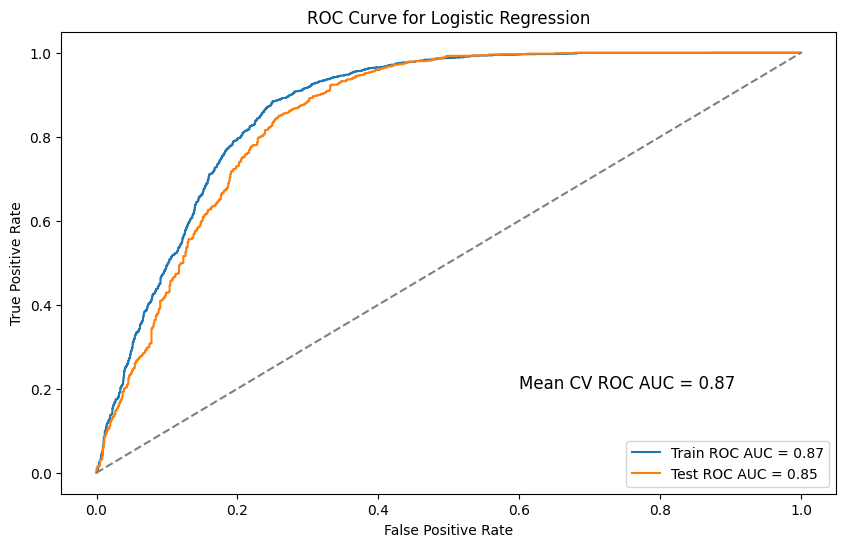

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Perform cross-validation and calculate ROC AUC for each fold
cv_auc_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc')

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Predict probabilities on the training and test sets
train_probs = log_reg.predict_proba(X_train)[:, 1]
test_probs = log_reg.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and ROC AUC for the training set
train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
train_auc = roc_auc_score(y_train, train_probs)

# Calculate the ROC curve and ROC AUC for the test set
test_fpr, test_tpr, _ = roc_curve(y_test, test_probs)
test_auc = roc_auc_score(y_test, test_probs)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label=f'Train ROC AUC = {train_auc:.2f}')
plt.plot(test_fpr, test_tpr, label=f'Test ROC AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')

# Add cross-validation AUC score to the plot
mean_cv_auc = np.mean(cv_auc_scores)
plt.text(0.6, 0.2, f'Mean CV ROC AUC = {mean_cv_auc:.2f}', fontsize=12)

plt.savefig('ROC_curve_LR_with_CV.png')
plt.show()


In [37]:
# Calculate and print the accuracy for training and test sets
train_accuracy = accuracy_score(y_train, log_reg.predict(X_train))
test_accuracy = accuracy_score(y_test, log_reg.predict(X_test))
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Calculate F1 score for the training set
train_f1 = f1_score(y_train, log_reg.predict(X_train))

# Calculate F1 score for the test set
test_f1 = f1_score(y_test, log_reg.predict(X_test))

print(f'Training F1 Score: {train_f1:.2f}')
print(f'Test F1 Score: {test_f1:.2f}')

Training Accuracy: 0.81
Test Accuracy: 0.79
Training F1 Score: 0.83
Test F1 Score: 0.81


1. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
2. Because the curves for both training and test are close, it suggests there is not much overfitting. 
3. In summary, this ROC curve suggests that our logistic regression model has good predictive power and generalizes well from training to test data, with an AUC of 0.85 on the test set indicating strong performance.
4. An F1 score of 0.81 on the test set is generally considered a strong score, indicating that the model has a good balance between precision and recall on data it has not seen before.

**KNN**

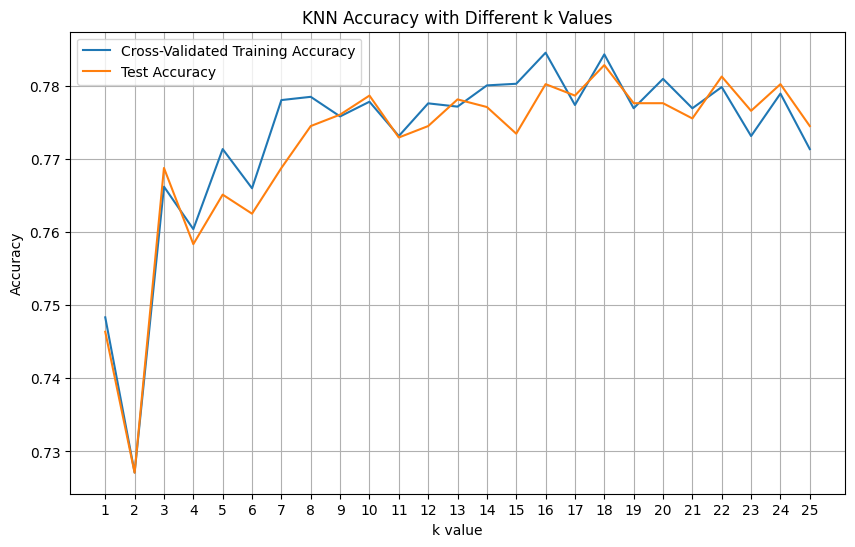

In [45]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

X, X_train, X_test, y, y_train, y_test = preprocess_inputs(data)
# Initialize lists to store the accuracies for different k values
knn_cv_accuracies = []
knn_test_accuracies = []

# Define a range of k values to try
k_values = range(1, 26)

# Number of folds for cross-validation
n_folds = 5

# Loop over the different k values
for k in k_values:
    # Initialize the KNeighborsClassifier with the current k
    knn = KNeighborsClassifier(n_neighbors=k)

    # Perform cross-validation and calculate mean accuracy
    cv_accuracies = cross_val_score(knn, X_train, y_train, cv=n_folds, scoring='accuracy')
    cv_mean_accuracy = cv_accuracies.mean()
    knn_cv_accuracies.append(cv_mean_accuracy)

    # Fit the model on the training data
    knn.fit(X_train, y_train)

    # Evaluate the model on the test data and append the accuracy to the list
    test_accuracy = knn.score(X_test, y_test)
    knn_test_accuracies.append(test_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_cv_accuracies, label='Cross-Validated Training Accuracy')
plt.plot(k_values, knn_test_accuracies, label='Test Accuracy')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy with Different k Values')
plt.legend()
plt.xticks(k_values)
plt.grid(True)
plt.savefig('KNN.png')
plt.show()


1. Overfitting at k=1.
2. Stabilization of Accuracies: Beyond k=6, both training and test accuracies seem to stabilize without significant fluctuations.
3. k = 5 or k = 6 will be optimal

In [67]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Splitting the data
X, X_train, X_test, y, y_train, y_test = preprocess_inputs(data)

# Cross-validation on training data for KNN
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=6), X_train, y_train, cv=10, scoring='accuracy')

# Cross-validation on training data for Logistic Regression
logreg_cv_scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=10, scoring='accuracy')

# Training KNN on the full training data
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

# Training Logistic Regression on the full training data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Evaluating KNN on the test data
knn_test_accuracy = accuracy_score(y_test, knn.predict(X_test))

# Evaluating Logistic Regression on the test data
logreg_test_accuracy = accuracy_score(y_test, logreg.predict(X_test))

# Print the results
print(f'KNN Average Training Accuracy: {knn_cv_scores.mean():.4f} (+/- {knn_cv_scores.std() * 2:.4f})')
print(f'KNN Test Accuracy: {knn_test_accuracy:.4f}')
print(f'Logistic Regression Average Training Accuracy: {logreg_cv_scores.mean():.2f} (+/- {logreg_cv_scores.std() * 2:.2f})')
print(f'Logistic Regression Test Accuracy: {logreg_test_accuracy:.2f}')


KNN Average Training Accuracy: 0.7709 (+/- 0.0307)
KNN Test Accuracy: 0.7625
Logistic Regression Average Training Accuracy: 0.81 (+/- 0.03)
Logistic Regression Test Accuracy: 0.79


**Random Forest**

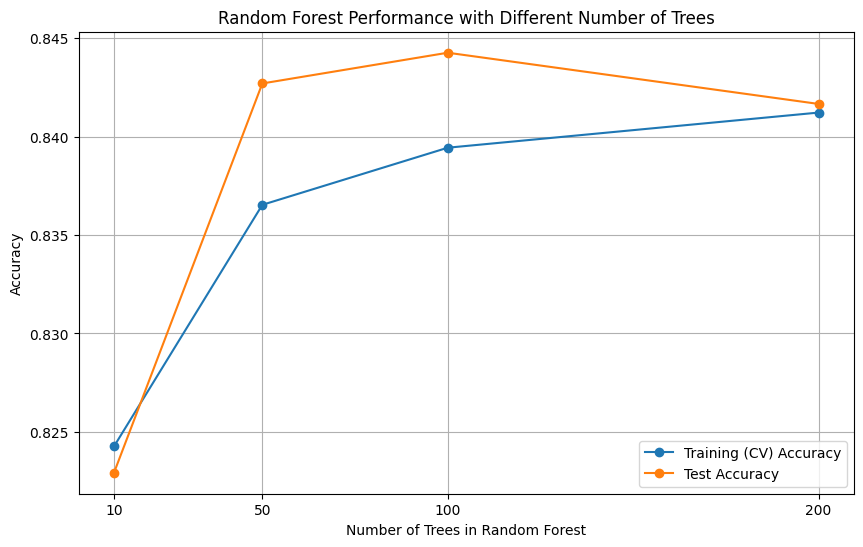

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# Splitting the data
X, X_train, X_test, y, y_train, y_test = preprocess_inputs(data)

# Define a range of 'n_estimators' values to explore
n_estimators_range = [10, 50, 100, 200]

# Lists to store mean cross-validated accuracies for each value of 'n_estimators'
cv_mean_accuracies = []
test_accuracies = []

# Number of folds for cross-validation
n_folds = 5

for n_estimators in n_estimators_range:
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=1)

    # Perform cross-validation and calculate mean accuracy
    cv_accuracies = cross_val_score(rf, X_train, y_train, cv=n_folds, scoring='accuracy')
    cv_mean_accuracy = cv_accuracies.mean()
    cv_mean_accuracies.append(cv_mean_accuracy)

    # Fit the model on the entire training set and evaluate on the test set
    rf.fit(X_train, y_train)
    y_test_pred = rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, cv_mean_accuracies, label='Training (CV) Accuracy', marker='o')
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Number of Trees in Random Forest')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance with Different Number of Trees')
plt.legend()
plt.xticks(n_estimators_range)
plt.grid(True)

plt.savefig('RF.png')
plt.show()

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Splitting the data
X, X_train, X_test, y, y_train, y_test = preprocess_inputs(data)

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)

# Perform cross-validation and calculate mean accuracy
cv_scores = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='accuracy')
cv_mean_accuracy = cv_scores.mean()

# Fit the model on the entire training data
random_forest.fit(X_train, y_train)

# Calculate and test accuracy
y_test_pred = random_forest.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print
print(f'Cross-Validated Training Accuracy: {cv_mean_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Feature importance and top 5 features
importances = random_forest.feature_importances_
top_5_features = np.argsort(importances)[::-1][:5]
features = X_train.columns
print("Top 5 features:")
for i, idx in enumerate(top_5_features):
    print(f"{i+1}. Feature {idx} ({features[idx]}): With importance {importances[idx]:.4f}")


Cross-Validated Training Accuracy: 0.8361
Test Accuracy: 0.8370
Top 5 features:
1. Feature 7 (instrumentalness): With importance 0.2469
2. Feature 3 (loudness): With importance 0.1003
3. Feature 1 (energy): With importance 0.0949
4. Feature 6 (acousticness): With importance 0.0945
5. Feature 0 (danceability): With importance 0.0863


In [57]:
# models = {
#     "                   Logistic Regression": LogisticRegression(random_state=42),
#     "                   K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=10),
#     "                         Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
#     "                        Neural Network": MLPClassifier(),

# }

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     print(name + " trained.")

In [58]:
# for name, model in models.items():
#     print(name + " test    : {:.2f}%".format(model.score(X_test, y_test) * 100))
#     print(name + " training: {:.2f}%".format(model.score(X_train, y_train) * 100))


**Neural Network**

In [61]:
# Splitting the data
X, X_train, X_test, y, y_train, y_test = preprocess_inputs(data)


# Initialize the MLPClassifier
mlp_100 = MLPClassifier(max_iter=100, random_state=1)
# Train the model
mlp_100.fit(X_train, y_train)

# Evaluate the model
train_score = mlp_100.score(X_train, y_train)
test_score = mlp_100.score(X_test, y_test)

print(f"Training Accuracy: {train_score}")
print(f"Test Accuracy: {test_score}")


Training Accuracy: 0.8613220187583742
Test Accuracy: 0.8182291666666667


In [66]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Initialize the MLPClassifier
mlp = MLPClassifier(max_iter=1, warm_start=True, random_state=1, learning_rate_init=0.001)

# Lists to store metrics
test_accuracy = []
test_loss = []
train_accuracy = []
train_loss = []

# List to store the (epoch, train_accuracy, test_accuracy) tuples
accuracy_tuples = []

# Number of epochs
n_epochs = 100

for epoch in range(n_epochs):
    # Train for one epoch
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

    # Make predictions on test set
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)

    # Make predictions on train set
    y_train_pred = mlp.predict(X_train)
    y_train_prob = mlp.predict_proba(X_train)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    test_accuracy.append(accuracy)

    # Calculate loss
    loss = log_loss(y_test, y_prob)
    test_loss.append(loss)

    # Calculate train accuracy and loss
    train_acc = np.mean(y_train_pred == y_train)
    train_accuracy.append(train_acc)
    train_loss.append(log_loss(y_train, y_train_prob))

    # Store the epoch, train accuracy, and test accuracy tuple
    accuracy_tuples.append((epoch, train_acc, accuracy))

# Find the tuple with the highest test accuracy
highest_test_accuracy_tuple = max(accuracy_tuples, key=lambda x: x[2])

print(f"Epoch with the highest test accuracy: {highest_test_accuracy_tuple[0]}")
print(f"Training Accuracy: {highest_test_accuracy_tuple[1]:.4f}")
print(f"Test Accuracy: {highest_test_accuracy_tuple[2]:.4f}")



Epoch with the highest test accuracy: 73
Training Accuracy: 0.8557
Test Accuracy: 0.8229


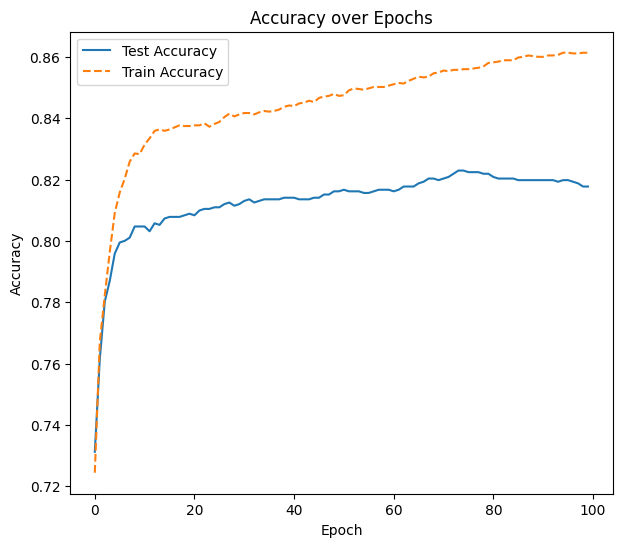

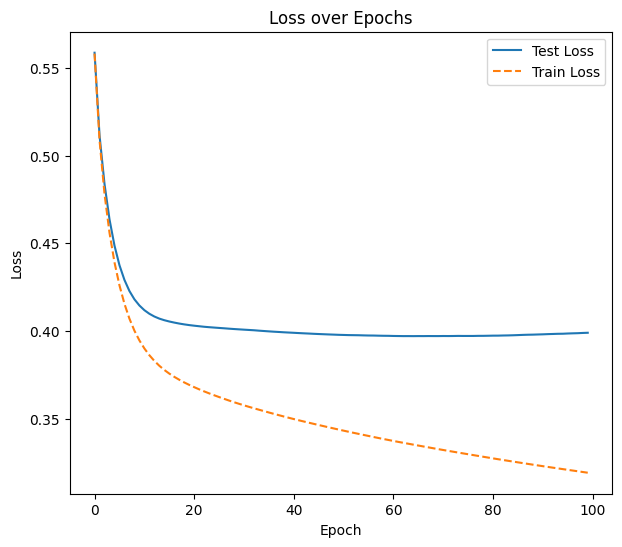

In [64]:
plt.figure(figsize=(7, 6))  # Create a new figure for accuracy
plt.plot(test_accuracy, label='Test Accuracy')
plt.plot(train_accuracy, label='Train Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('NN_Accuracy.png')  # Save the accuracy figure
plt.show()


plt.figure(figsize=(7, 6))  # Create a new figure for loss
plt.plot(test_loss, label='Test Loss')
plt.plot(train_loss, label='Train Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('NN_Loss.png')  # Save the loss figure
plt.show()



$P(Y = 1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}}$


$\text{Euclidean distance}: d(\mathbf{x}, \mathbf{x'}) = \sqrt{\sum_{i=1}^{n} (x_i - x'_i)^2}
$

$f(x) = \sum_{i=1}^{B} f_i(x)$

$a_l = g_l(W_l a_{l-1} + b_l)$